# Checking individual submissions for validity

This notebook helps me investigate individual submissions in prolific. It has three main goals:

1. maintaining and updating a table with the prolific ID, jatos worker ID, and session status that participants on prolific completed
2. Visualizing the data from individual sessions to make a decision whether to include or exclude this participant from the experiment.
3. Merging data into a comon file for analysis

### Adding missing trials and questionnaires

In some sessions, the participants encountered technical difficulties - the data upload would be very slow at the end of the main session. When participants encountered this problem, they often tried to reload the page, leading to the loss of some trials, and a missing questionnaire. The trials that were saved are stored in the folder '**incomplete_main_sessions**' and will be loaded from there.

If more than 10 trials got lost this way, I compared precomputed timeline variables with the completed timeline variables, and set up an individual experiment for the participants to repeat the missing trials, and answer the questionnaire in the end. This data from the individual experiments is collected in the file '**additional_datafile**'

When less then 10 trials were missing, I sent participants the questions in the prolific chat and manually added their responses to the file '**missing_questionnaire.csv**'. If the experiment failed twice in a row, I asked participants to complete all 4 sessions from the main experiment first, and set up a follow-up session with all missing trials in the end. This procedure was needed for one participant (5ae0b548e0feeb0001cafc45)

In total, there are 13 missing trials that were not recorded due to technical failures.

ADDITIONAL TRIALS:

601912bdba58d50172d0c737 - jatos worker 7430 - 1 trial missing from 1st session, and no quizz

5ae0b548e0feeb0001cafc45 - jatos worker 7408 - repeat missed trials from session 1 - https://jatos.psychologie.hu-berlin.de/publix/245/start?batchId=395&generalMultiple&SESSION_NUMBER=1&PROLIFIC_PID=5ae0b548e0feeb0001cafc45&SESSION_ID=6218a0d7e87d7b2060c1ecc0&STUDY_ID=6216b9e017f1b071285af3e9

5ae0b548e0feeb0001cafc45 - repeat missed trials from session 2, 3 & 4 - https://jatos.psychologie.hu-berlin.de/publix/245/start?batchId=395&generalMultiple&PROLIFIC_PID=5ae0b548e0feeb0001cafc45


611a877bcd96a7f29f70230a - jatos worker 7423 - repeat missed trials from session 1 -
https://jatos.psychologie.hu-berlin.de/publix/245/start?batchId=395&generalMultiple&SESSION_NUMBER=1&PROLIFIC_PID=611a877bcd96a7f29f70230a&SESSION_ID=6218a12c408ae471d193aa14&STUDY_ID=6216b9e017f1b071285af3e9

610afb895c8cef9f6ec1ac6a - Experiment Repetition Session 2
https://jatos.psychologie.hu-berlin.de/publix/239/start?batchId=380&generalMultiple&SESSION_NUMBER=2&PROLIFIC_PID=610afb895c8cef9f6ec1ac6a&STUDY_ID=6216b9f6fa734c0a4acefab5&SESSION_ID=manually_added

60a97537bf4b23dbaba42403 - jatos worker 7607 - repeat missed trials from session 4 -
https://jatos.psychologie.hu-berlin.de/publix/245/start?batchId=395&generalMultiple&SESSION_NUMBER=4&PROLIFIC_PID=60a97537bf4b23dbaba42403&SESSION_ID=621f1bbfec08992dd1fc9794&STUDY_ID=6216bbcec318b5df4e482581


### Imports

In [1]:
import json
import numpy as np
import os
import pandas as pd
from pandas.testing import assert_frame_equal

## Paths

In [2]:
datapath = '../data/study_data_multiple_sessions/'
overview_file_path =  datapath + 'participants_overview.csv'
prolific_path =  datapath + 'metadata_prolific/'
incomplete_main_path = datapath + 'incomplete_main_sessions/'
jatos_rawfile_path =  datapath + 'full_datafile.txt'
jatos_extrafile_path = datapath + 'additional_datafile.txt'
jatos_extraquestion_path = datapath + 'missing_questionnaire.csv'
jatos_datafile_path = datapath + 'full_datafile.csv'

## Loader Functions

In [3]:
# step one - check if the jatos json file has been translated into csv already
def load_rawjson(file):
    data = {}

    with open(file) as f:
        # unpack the data
        for ses, jf in enumerate(f):
            # save it to a data frame
            df = pd.read_json(jf)
            try:
                data = pd.concat([data,df], axis = 0)
            except:
                data = df
    return data

def load_json_from_path(pathname):
    data = pd.DataFrame()
    
    for file in os.listdir(pathname):
        df = pd.read_json(pathname+file)
        data = pd.concat([data, df], ignore_index = True)
    return data

def raw_jatosdata_to_csv(source_file, incomplete_path, extra_file, extra_questions, destiny_file):
    try: 
        if os.path.getmtime(source_file)>os.path.getmtime(destiny_file) or os.path.getmtime(extra_file)>os.path.getmtime(destiny_file):
            print('The raw data file was updated - Loading again.')
        else: 
            print('The file is up-to-date.')
            return
    
    except FileNotFoundError:
            print('Creating a new data file from raw json.')
    
    # load and append incomplete files
    source_to_pandas = load_rawjson(source_file)
    incomplete_main = load_json_from_path(incomplete_main_path)
    extra_to_pandas = load_rawjson(extra_file)
    extra_questionnaire = pd.read_csv(extra_questions)
    source_to_pandas = pd.concat([source_to_pandas, incomplete_main, extra_to_pandas, extra_questionnaire], ignore_index = True)
    source_to_pandas.to_csv(destiny_file, index = False)

raw_jatosdata_to_csv(jatos_rawfile_path, incomplete_main_path, jatos_extrafile_path, jatos_extraquestion_path, jatos_datafile_path)

The raw data file was updated - Loading again.


## Check and update overview file

In [4]:
def set_participant_session_data(experiment_data_path, prolific_data_path, participant_overview_path):
    overview_data_file = pd.read_csv(participant_overview_path)
    experiment_data_file = pd.read_csv(experiment_data_path)
    experiment_data_file = experiment_data_file[experiment_data_file.component == 'Outro_General'].dropna(axis = 1)

    for filename in os.listdir(prolific_data_path):
        if '_session_' in filename:
            colname = filename.split('meta_')[1].split('.csv')[0]
            
            if not colname in overview_data_file.columns:
                raise ValueError('This column did not exist')
                
            prolific_data_file = pd.read_csv(prolific_data_path + filename)
            pid_in_session = np.unique(prolific_data_file.participant_id)
            
            for pid in pid_in_session:
                if pid in experiment_data_file.prolific_id.values:
                    if not pid in overview_data_file.prolific_id.values:
                        pid_pos = len(overview_data_file)
                        overview_data_file.loc[pid_pos, 'prolific_id'] = pid
                        overview_data_file.loc[pid_pos, 'jatos_worker'] = experiment_data_file.loc[experiment_data_file.prolific_id == pid, 'subject'].iloc[0]
                    if not type(overview_data_file.loc[overview_data_file.prolific_id == pid, colname].values[0]) == str or overview_data_file.loc[overview_data_file.prolific_id == pid, colname].values[0] == 'ACCESS_GIVEN':
                        overview_data_file.loc[overview_data_file.prolific_id == pid, colname] = 'COMPLETED'
    
    overview_data_file.to_csv(participant_overview_path, index = False)              
    return overview_data_file               

In [5]:
overview_data = set_participant_session_data(jatos_datafile_path, prolific_path, overview_file_path)
overview_data

,prolific_id,jatos_worker,session_1,session_2,session_3,session_4,Unnamed: 6
0,5baf6705848bbd0001d6fc8a,7465,ACCEPTED,ACCEPTED,ACCEPTED,ACCEPTED,NaN
1,5e4554f745ab32032eb5205b,7395,ACCEPTED,ACCEPTED,ACCEPTED,ACCEPTED,NaN
2,5eb3a734d249ac18a413063a,7396,ACCEPTED,ACCEPTED,ACCEPTED,ACCEPTED,NaN
3,5f9f4660d0edb75784c68223,7416,ACCEPTED,ACCEPTED,ADDED,NaN,NaN
4,5fa91c5d816c5c831297d606,7445,ACCEPTED,ACCEPTED,ACCEPTED,ACCEPTED,NaN
5,5fba72b83109906e0316581f,7403,ACCEPTED,ACCEPTED,ACCEPTED,ACCEPTED,NaN
6,602cfa22f252026258559aa4,7392,ACCEPTED,ACCEPTED,ACCEPTED,ACCEPTED,NaN
7,60a44706b01d415447a40545,7380,ACCEPTED,ACCEPTED,ACCEPTED,ACCEPTED,NaN
8,60a97537bf4b23dbaba42403,7424,ACCEPTED,ACCEPTED,ACCEPTED,ACCEPTED,NaN
9,60cb4f111e27b7ab3656e188,7428,ACCEPTED,ACCEPTED,ACCEPTED,ACCEPTED,6 trials missing


## Participant evaluation dashboard 
- choose participant via dropdown
- choose session via dropdown
- shown animation frame rates
- show x-correlation
- show y-correlation
- show survery responses

### Imports

In [6]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib notebook

### Define Dropdown Menues

In [7]:
participant = widgets.Dropdown(
    options=overview_data.prolific_id.values,
    value=overview_data.prolific_id.values[2],
    description='participant:',
    disabled=False,
)

session = widgets.Dropdown(
    options=['1', '2', '3', '4'],
    value='1',
    description='session:',
    disabled=False,
)

### Function Definitions

In [8]:
def extract_arrays_from_string(data, column):
    list_data = []

    for i in data.index[1:]:
        try:
            data_values = json.loads(data[column][i])
        except TypeError:
            data_values = data[column][i]
        list_data.append(data_values)
    return list_data

def fit_accuracy(data, ax, touchcol, positioncol):
    
    try:
        touch_list = extract_arrays_from_string(data, touchcol)
        target_list = extract_arrays_from_string(data, positioncol)
    except TypeError:
        touch_list = data[touchcol].values
        target_list = data[positioncol].values
        
    all_touches = np.concatenate(touch_list).flatten()
    all_targets = np.concatenate(target_list).flatten()
    ax.clear()
    
    # plot
    ax.scatter(all_targets, all_touches)
    correlation_coef = np.corrcoef(all_targets, all_touches)
    ax.plot(all_targets, all_targets * correlation_coef[0,1] + np.mean(all_touches), color = 'magenta')
    ax.set_title(f'pearson correlation: {round(correlation_coef[0,1],2)}')    

In [9]:
def show_flip_accuracy(data,ax):
    
    try:
        timestamp_data = extract_arrays_from_string(data, 'animation_timestamps')
    except TypeError:
        print('Type Error occurred')
        timestamp_data = data['animation_timestamps'].values

    difference_data_animation = pd.DataFrame(timestamp_data).diff(axis=1).dropna(axis = 1)
    missed_frames = np.where(difference_data_animation > 2 * np.mean(difference_data_animation))[0]
    print(f"{len(np.unique(missed_frames))} trials were dropped due to timing problems")
    # return difference_data_animation
    difference_data_animation.drop(missed_frames, inplace = True)
    description_data = difference_data_animation.describe()
    ax.clear()

    ax.plot(description_data.T.index, description_data.T['mean'])
    ax.fill_between(description_data.T.index, 
                                    description_data.T['mean']+description_data.T['std'], 
                                    description_data.T['mean']-description_data.T['std'], 
                                    alpha = 0.5 )
    ax.set_title('Difference between Flips')
    ax.set_xlabel('Flip ID');

### Show interactive plot

<IPython.core.display.Javascript object>


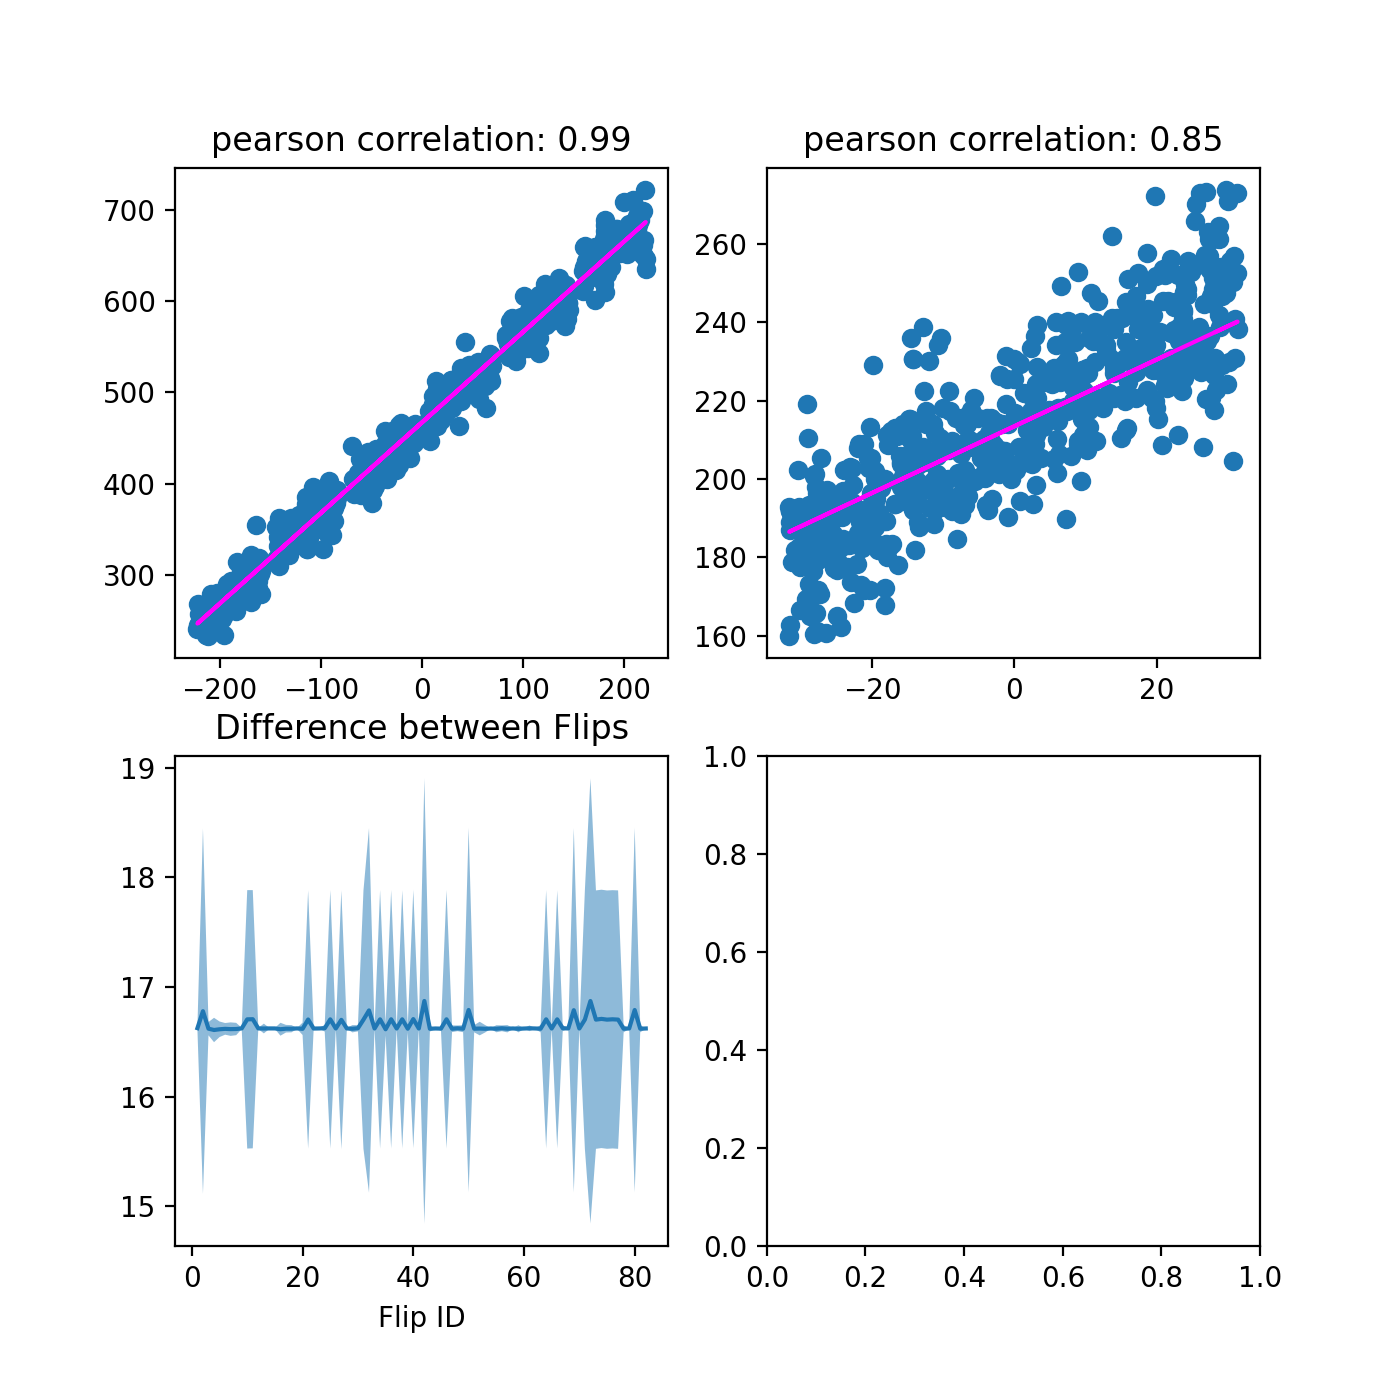

interactive(children=(Dropdown(description='participant:', index=2, options=('5baf6705848bbd0001d6fc8a', '5e45…

In [10]:
fig, axs = plt.subplots(2,2, figsize = (7,7))
experiment_data = pd.read_csv(jatos_datafile_path)    
@widgets.interact(participant = participant, session = session)
def plot_participant_session_data(participant = participant, session = session):
    
    trial_data = experiment_data[experiment_data.component == 'Trials_Serial']
    trial_data = trial_data[trial_data.test_part == 'trial']
    trial_data = trial_data[trial_data.success == 1.0]
    participant_data = trial_data[trial_data.prolific_id == participant]
    session_data = participant_data[participant_data.session_number == int(session)].reset_index(drop = True)
    noshift_data = session_data[session_data.stimJumped == 0].reset_index(drop = True)
    fit_accuracy(noshift_data, axs[0,0], 'touchX', 'position_x')    
    fit_accuracy(noshift_data, axs[0,1], 'touchY', 'position_y')
    show_flip_accuracy(session_data, axs[1,0])
    
    questionnaire_data = experiment_data[experiment_data.component == 'Outro_General']
    participant_questions_data = questionnaire_data[questionnaire_data.prolific_id == participant]
    session_questions_data = participant_questions_data[participant_questions_data.session_number == int(session)]
    session_questions_data = session_questions_data.reset_index(drop = True)
    
    prolific_data_file = pd.read_csv(prolific_path + f'prolific_meta_session_{session}.csv')
    prolific_subject = prolific_data_file[prolific_data_file.participant_id == participant]
    
    print(f"n trials: {len(session_data)}")
    print(f"concentration: {session_questions_data[session_questions_data.test_part == 'outro_concentration'].survey_response.values[0]}")
    print(f"finger: {session_questions_data[session_questions_data.test_part == 'outro_finger'].survey_response.values[0]}")    
    print(f"screen: {session_questions_data[session_questions_data.test_part == 'outro_screen'].survey_response.values[0]}")    
    print(f"hand: {session_questions_data[session_questions_data.test_part == 'outro_hand'].survey_response.values[0]}")    
    print(f"comments: {session_questions_data[session_questions_data.test_part == 'outro_comments'].survey_response.values[0]}")    
    print(f"width: {np.unique(session_data.windowWidth)}")    
    print(f"height: {np.unique(session_data.windowHeight)}")    
    print(f"platform: {np.unique(session_data.userInfo)}")    
    print(f"user agent: {np.unique(session_data.platform)}")
    print(f"duration prolific: {prolific_subject.time_taken / 60}")
    print(f"duration jatos: {(session_data.time_elapsed.loc[len(session_data)-1] - session_data.time_elapsed[0])/60000}")
    
    

### Load an check incomplete main sessions

The worker ID has be entered manually here.

In [11]:
worker_id = 7608
worker = pd.read_json(datapath + f'rejected_participants/worker_{worker_id}.json')
worker = worker[worker.test_part == 'trial']
print(f"Before cleaning, this dataset had {len(worker)} trials.")
worker = worker[worker.success == 1]
print(f"After cleaning, this dataset had {len(worker)} trials.")

Before cleaning, this dataset had 207 trials.
After cleaning, this dataset had 150 trials.


<IPython.core.display.Javascript object>


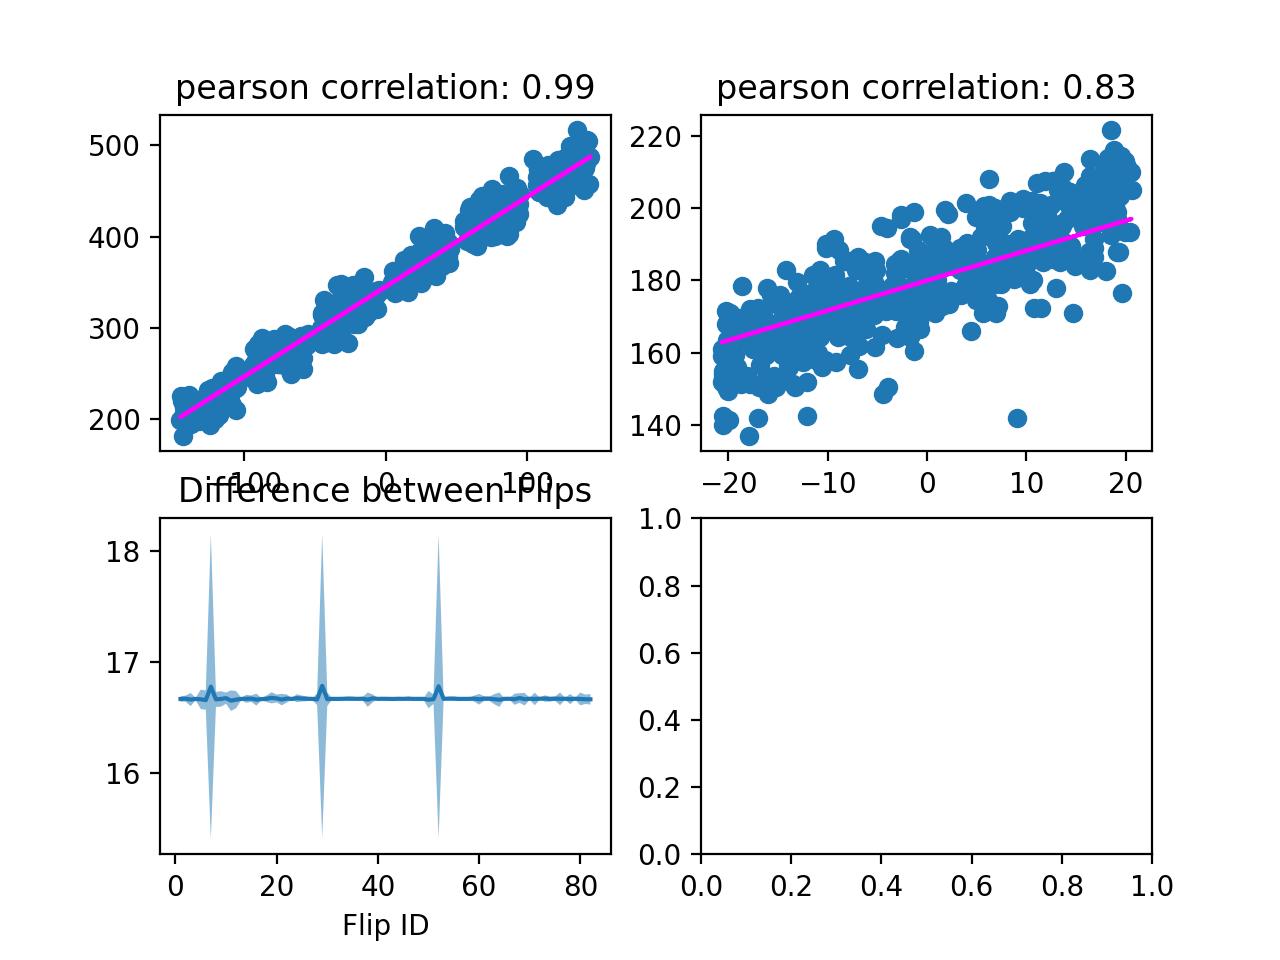

2 trials were dropped due to timing problems
n trials: 150
width: [681.]
height: [336. 360.]
platform: ['Mozilla/5.0 (Linux; Android 8.0.0; LDN-L01) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.98 Mobile Safari/537.36']
user agent: ['Linux armv8l']
duration prolific: 8    1723.31895
Name: time_taken, dtype: float64
duration jatos: 14.940033333333334


In [12]:
incomplete_fig, incomplete_axs = plt.subplots(2,2)

session_data = worker.reset_index(drop = True)
noshift_data = session_data[session_data.stimJumped == 0].reset_index(drop = True)
fit_accuracy(noshift_data, incomplete_axs[0,0], 'touchX', 'position_x')    
fit_accuracy(noshift_data, incomplete_axs[0,1], 'touchY', 'position_y')
show_flip_accuracy(session_data, incomplete_axs[1,0])

ses = int(np.unique(session_data.session_number))
par = np.unique(session_data.prolific_id)[0]

prolific_data_file = pd.read_csv(prolific_path + f'prolific_meta_session_{ses}.csv')
prolific_subject = prolific_data_file[prolific_data_file.participant_id == par]

print(f"n trials: {len(session_data)}")
print(f"width: {np.unique(session_data.windowWidth)}")    
print(f"height: {np.unique(session_data.windowHeight)}")    
print(f"platform: {np.unique(session_data.userInfo)}")    
print(f"user agent: {np.unique(session_data.platform)}")
print(f"duration prolific: {prolific_subject.time_taken / 60}")
print(f"duration jatos: {(session_data.time_elapsed.loc[len(session_data)-1] - session_data.time_elapsed[0])/60000}")


### Extract incomplete trials and save them for extra session

In [13]:
# identify uncompleted trials
def find_completed_trials(worker_id):
    worker = pd.read_json(datapath + f'rejected_participants/worker_{worker_id}.json')
    worker = worker[worker.test_part == 'trial']
    trial_ids = worker[worker.success == 1].trialID
    
    return trial_ids

def get_uncompleted_trials(worker_id, trial_ids):
    timeline_vars = pd.read_json(datapath + f'rejected_participants/allTimelineVariables_{worker_id}.json')
    repeat_trials = timeline_vars[timeline_vars.trialID.isin(trial_ids) == False]
    return repeat_trials

The worker ids need to be set manually here.

In [14]:
all_workers = [7665, 7705, 7729]
for worker in all_workers:
    ids = find_completed_trials(worker)
    repeat_trials = get_uncompleted_trials(worker, ids).reset_index(drop=True)
    
    # repeat_trials.to_json(datapath + f'rejected_participants/trials_{worker}.json', orient = 'records')

### Manual correction of missing data

Since participant 5ae0b548e0feeb0001cafc45 completed all extra trials in one run, there are some paramters missing - i.e. we didn't save a session id or study id. We saved the session number in all but two trials. Here we add these missing number manually. 

In [15]:
missing_session_number = np.where(experiment_data.session_number.isnull() & experiment_data.success == 1)
missing_session_data =  experiment_data.iloc[missing_session_number]
missing_session_data = missing_session_data[missing_session_data.trial_type == 'canvas-mi-serial']

session_3_id = missing_session_data[missing_session_data.trialID == 185].index
session_4_id = missing_session_data[missing_session_data.trialID == 8].index

experiment_data.loc[session_3_id, 'session_number'] = 3
experiment_data.loc[session_4_id, 'session_number'] = 4

In [16]:
session_id_2 = '621fb3bfd880d8d0e1fd44ae'
session_id_3 = '622091b3a577c6d522b391cb'
session_id_4 = '6220e28a584f925fcdfc9ded'

study_id_2 = '6216b9f6fa734c0a4acefab5'
study_id_3 = '6216bb63e6411c3f058a4480'
study_id_4 = '6216bbcec318b5df4e482581'

subject_data = experiment_data[experiment_data.prolific_id == '5ae0b548e0feeb0001cafc45']

ids_2 = subject_data[subject_data.session_number == 2].index
ids_3 = subject_data[subject_data.session_number == 3].index
ids_4 = subject_data[subject_data.session_number == 4].index

In [17]:
experiment_data.loc[ids_2, 'session_id'] = session_id_2
experiment_data.loc[ids_3, 'session_id'] = session_id_3
experiment_data.loc[ids_4, 'session_id'] = session_id_4

experiment_data.loc[ids_2, 'study_id'] = study_id_2
experiment_data.loc[ids_3, 'study_id'] = study_id_3
experiment_data.loc[ids_4, 'study_id'] = study_id_4

In [18]:
experiment_data.to_csv(jatos_datafile_path, index = False)